# 个性化推荐

本教程源代码目录在[book/recommender_system](https://github.com/PaddlePaddle/book/tree/develop/05.recommender_system)， 初次使用请参考PaddlePaddle[安装教程](https://github.com/PaddlePaddle/book/blob/develop/README.cn.md#运行这本书)，更多内容请参考本教程的[视频课堂](http://bit.baidu.com/course/detail/id/176.html)。

## 背景介绍

在网络技术不断发展和电子商务规模不断扩大的背景下，商品数量和种类快速增长，用户需要花费大量时间才能找到自己想买的商品，这就是信息超载问题。为了解决这个难题，推荐系统（Recommender System）应运而生。

个性化推荐系统是信息过滤系统（Information Filtering System）的子集，它可以用在很多领域，如电影、音乐、电商和 Feed 流推荐等。推荐系统通过分析、挖掘用户行为，发现用户的个性化需求与兴趣特点，将用户可能感兴趣的信息或商品推荐给用户。与搜索引擎不同，推荐系统不需要用户准确地描述出自己的需求，而是根据分析历史行为建模，主动提供满足用户兴趣和需求的信息。

传统的推荐系统方法主要有：

- 协同过滤推荐（Collaborative Filtering Recommendation）：该方法收集分析用户历史行为、活动、偏好，计算一个用户与其他用户的相似度，利用目标用户的相似用户对商品评价的加权评价值，来预测目标用户对特定商品的喜好程度。优点是可以给用户推荐未浏览过的新产品；缺点是对于没有任何行为的新用户存在冷启动的问题，同时也存在用户与商品之间的交互数据不够多造成的稀疏问题，会导致模型难以找到相近用户。
- 基于内容过滤推荐[[1](#参考文献)]（Content-based Filtering Recommendation）：该方法利用商品的内容描述，抽象出有意义的特征，通过计算用户的兴趣和商品描述之间的相似度，来给用户做推荐。优点是简单直接，不需要依据其他用户对商品的评价，而是通过商品属性进行商品相似度度量，从而推荐给用户所感兴趣商品的相似商品；缺点是对于没有任何行为的新用户同样存在冷启动的问题。
- 组合推荐[[2](#参考文献)]（Hybrid Recommendation）：运用不同的输入和技术共同进行推荐，以弥补各自推荐技术的缺点。

其中协同过滤是应用最广泛的技术之一，它又可以分为多个子类：基于用户 （User-Based）的推荐[[3](#参考文献)] 、基于物品（Item-Based）的推荐[[4](#参考文献)]、基于社交网络关系（Social-Based）的推荐[[5](#参考文献)]、基于模型（Model-based）的推荐等。1994年明尼苏达大学推出的GroupLens系统[[3](#参考文献)]一般被认为是推荐系统成为一个相对独立的研究方向的标志。该系统首次提出了基于协同过滤来完成推荐任务的思想，此后，基于该模型的协同过滤推荐引领了推荐系统十几年的发展方向。

深度学习具有优秀的自动提取特征的能力，能够学习多层次的抽象特征表示，并对异质或跨域的内容信息进行学习，可以一定程度上处理推荐系统冷启动问题[[6](#参考文献)]。本教程主要介绍个性化推荐的深度学习模型，以及如何使用PaddlePaddle实现模型。

## 效果展示

我们使用包含用户信息、电影信息与电影评分的数据集作为个性化推荐的应用场景。当我们训练好模型后，只需要输入对应的用户ID和电影ID，就可以得出一个匹配的分数（范围[0,5]，分数越高视为兴趣越大），然后根据所有电影的推荐得分排序，推荐给用户可能感兴趣的电影。

```
Input movie_id: 1962
Input user_id: 1
Prediction Score is 4.25
```

## 模型概览

本章中，我们首先介绍YouTube的视频推荐系统[[7](#参考文献)]，然后介绍我们实现的融合推荐模型。

### YouTube的深度神经网络推荐系统

YouTube是世界上最大的视频上传、分享和发现网站，YouTube推荐系统为超过10亿用户从不断增长的视频库中推荐个性化的内容。整个系统由两个神经网络组成：候选生成网络和排序网络。候选生成网络从百万量级的视频库中生成上百个候选，排序网络对候选进行打分排序，输出排名最高的数十个结果。系统结构如图1所示：

<p align="center">
<img src="image/YouTube_Overview.png" width="70%" ><br/>
图1. YouTube 推荐系统结构
</p>

#### 候选生成网络（Candidate Generation Network）

候选生成网络将推荐问题建模为一个类别数极大的多类分类问题：对于一个Youtube用户，使用其观看历史（视频ID）、搜索词记录（search tokens）、人口学信息（如地理位置、用户登录设备）、二值特征（如性别，是否登录）和连续特征（如用户年龄）等，对视频库中所有视频进行多分类，得到每一类别的分类结果（即每一个视频的推荐概率），最终输出概率较高的几百个视频。

首先，将观看历史及搜索词记录这类历史信息，映射为向量后取平均值得到定长表示；同时，输入人口学特征以优化新用户的推荐效果，并将二值特征和连续特征归一化处理到[0, 1]范围。接下来，将所有特征表示拼接为一个向量，并输入给非线形多层感知器（MLP，详见[识别数字](https://github.com/PaddlePaddle/book/blob/develop/02.recognize_digits/README.cn.md)教程）处理。最后，训练时将MLP的输出给softmax做分类，预测时计算用户的综合特征（MLP的输出）与所有视频的相似度，取得分最高的$k$个作为候选生成网络的筛选结果。图2显示了候选生成网络结构。

<p align="center">
<img src="image/Deep_candidate_generation_model_architecture.png" width="70%" ><br/>
图2. 候选生成网络结构
</p>

对于一个用户$U$，预测此刻用户要观看的视频$\omega$为视频$i$的概率公式为：

$$P(\omega=i|u)=\frac{e^{v_{i}u}}{\sum_{j \in V}e^{v_{j}u}}$$

其中$u$为用户$U$的特征表示，$V$为视频库集合，$v_i$为视频库中第$i$个视频的特征表示。$u$和$v_i$为长度相等的向量，两者点积可以通过全连接层实现。

考虑到softmax分类的类别数非常多，为了保证一定的计算效率：1）训练阶段，使用负样本类别采样将实际计算的类别数缩小至数千；2）推荐（预测）阶段，忽略softmax的归一化计算（不影响结果），将类别打分问题简化为点积（dot product）空间中的最近邻（nearest neighbor）搜索问题，取与$u$最近的$k$个视频作为生成的候选。

#### 排序网络（Ranking Network）
排序网络的结构类似于候选生成网络，但是它的目标是对候选进行更细致的打分排序。和传统广告排序中的特征抽取方法类似，这里也构造了大量的用于视频排序的相关特征（如视频 ID、上次观看时间等）。这些特征的处理方式和候选生成网络类似，不同之处是排序网络的顶部是一个加权逻辑回归（weighted logistic regression），它对所有候选视频进行打分，从高到底排序后将分数较高的一些视频返回给用户。

### 融合推荐模型
本节会使卷积神经网络（Convolutional Neural Networks）来学习电影名称的表示。下面会依次介绍文本卷积神经网络以及融合推荐模型。

#### 文本卷积神经网络（CNN）

卷积神经网络经常用来处理具有类似网格拓扑结构（grid-like topology）的数据。例如，图像可以视为二维网格的像素点，自然语言可以视为一维的词序列。卷积神经网络可以提取多种局部特征，并对其进行组合抽象得到更高级的特征表示。实验表明，卷积神经网络能高效地对图像及文本问题进行建模处理。  

卷积神经网络主要由卷积（convolution）和池化（pooling）操作构成，其应用及组合方式灵活多变，种类繁多。本小结我们以如图3所示的网络进行讲解：

<p align="center">
<img src="image/text_cnn.png" width = "80%" align="center"/><br/>
图3. 卷积神经网络文本分类模型
</p>

假设待处理句子的长度为$n$，其中第$i$个词的词向量（word embedding）为$x_i\in\mathbb{R}^k$，$k$为维度大小。  

首先，进行词向量的拼接操作：将每$h$个词拼接起来形成一个大小为$h$的词窗口，记为$x_{i:i+h-1}$，它表示词序列$x_{i},x_{i+1},\ldots,x_{i+h-1}$的拼接，其中，$i$表示词窗口中第一个词在整个句子中的位置，取值范围从$1$到$n-h+1$，$x_{i:i+h-1}\in\mathbb{R}^{hk}$。  

其次，进行卷积操作：把卷积核(kernel)$w\in\mathbb{R}^{hk}$应用于包含$h$个词的窗口$x_{i:i+h-1}$，得到特征$c_i=f(w\cdot x_{i:i+h-1}+b)$，其中$b\in\mathbb{R}$为偏置项（bias），$f$为非线性激活函数，如$sigmoid$。将卷积核应用于句子中所有的词窗口${x_{1:h},x_{2:h+1},\ldots,x_{n-h+1:n}}$，产生一个特征图（feature map）：

$$c=[c_1,c_2,\ldots,c_{n-h+1}], c \in \mathbb{R}^{n-h+1}$$

接下来，对特征图采用时间维度上的最大池化（max pooling over time）操作得到此卷积核对应的整句话的特征$\hat c$，它是特征图中所有元素的最大值：

$$\hat c=max(c)$$  

#### 模型概览

在融合推荐模型的电影推荐系统中：

1. 首先，使用用户特征和电影特征作为神经网络的输入，其中：

   - 用户特征融合了四个属性信息，分别是用户ID、性别、职业和年龄。

   - 电影特征融合了三个属性信息，分别是电影ID、电影类型ID和电影名称。

2. 对用户特征，将用户ID映射为维度大小为256的向量表示，输入全连接层，并对其他三个属性也做类似的处理。然后将四个属性的特征表示分别全连接并相加。

3. 对电影特征，将电影ID以类似用户ID的方式进行处理，电影类型ID以向量的形式直接输入全连接层，电影名称用文本卷积神经网络得到其定长向量表示。然后将三个属性的特征表示分别全连接并相加。

4. 得到用户和电影的向量表示后，计算二者的余弦相似度作为推荐系统的打分。最后，用该相似度打分和用户真实打分的差异的平方作为该回归模型的损失函数。

<p align="center">

<img src="image/rec_regression_network.png" width="90%" ><br/>
图4. 融合推荐模型
</p>

## 数据准备

### 数据介绍与下载

我们以 [MovieLens 百万数据集（ml-1m）](http://files.grouplens.org/datasets/movielens/ml-1m.zip)为例进行介绍。ml-1m 数据集包含了 6,000 位用户对 4,000 部电影的 1,000,000 条评价（评分范围 1~5 分，均为整数），由 GroupLens Research 实验室搜集整理。

Paddle在API中提供了自动加载数据的模块。数据模块为 `paddle.dataset.movielens`




In [1]:
import paddle.v2 as paddle
paddle.init(use_gpu=False)


In [2]:
# Run this block to show dataset's documentation
# help(paddle.dataset.movielens)



在原始数据中包含电影的特征数据，用户的特征数据，和用户对电影的评分。

例如，其中某一个电影特征为:




In [3]:
movie_info = paddle.dataset.movielens.movie_info()
print movie_info.values()[0]


Cache file /root/.cache/paddle/dataset/movielens/ml-1m.zip not found, downloading http://files.grouplens.org/datasets/movielens/ml-1m.zip
[==================================================]<MovieInfo id(1), title(Toy Story ), categories(['Animation', "Children's", 'Comedy'])>



    <MovieInfo id(1), title(Toy Story ), categories(['Animation', "Children's", 'Comedy'])>


这表示，电影的id是1，标题是《Toy Story》，该电影被分为到三个类别中。这三个类别是动画，儿童，喜剧。




In [4]:
user_info = paddle.dataset.movielens.user_info()
print user_info.values()[0]


<UserInfo id(1), gender(F), age(1), job(10)>



    <UserInfo id(1), gender(F), age(1), job(10)>


这表示，该用户ID是1，女性，年龄比18岁还年轻。职业ID是10。


其中，年龄使用下列分布
*  1:  "Under 18"
* 18:  "18-24"
* 25:  "25-34"
* 35:  "35-44"
* 45:  "45-49"
* 50:  "50-55"
* 56:  "56+"

职业是从下面几种选项里面选则得出:
*  0:  "other" or not specified
*  1:  "academic/educator"
*  2:  "artist"
*  3:  "clerical/admin"
*  4:  "college/grad student"
*  5:  "customer service"
*  6:  "doctor/health care"
*  7:  "executive/managerial"
*  8:  "farmer"
*  9:  "homemaker"
* 10:  "K-12 student"
* 11:  "lawyer"
* 12:  "programmer"
* 13:  "retired"
* 14:  "sales/marketing"
* 15:  "scientist"
* 16:  "self-employed"
* 17:  "technician/engineer"
* 18:  "tradesman/craftsman"
* 19:  "unemployed"
* 20:  "writer"

而对于每一条训练/测试数据，均为 <用户特征> + <电影特征> + 评分。

例如，我们获得第一条训练数据:




In [5]:
train_set_creator = paddle.dataset.movielens.train()
train_sample = next(train_set_creator())
uid = train_sample[0]
mov_id = train_sample[len(user_info[uid].value())]
print "User %s rates Movie %s with Score %s"%(user_info[uid], movie_info[mov_id], train_sample[-1])


User <UserInfo id(1), gender(F), age(1), job(10)> rates Movie <MovieInfo id(1193), title(One Flew Over the Cuckoo's Nest ), categories(['Drama'])> with Score [5.0]



    User <UserInfo id(1), gender(F), age(1), job(10)> rates Movie <MovieInfo id(1193), title(One Flew Over the Cuckoo's Nest ), categories(['Drama'])> with Score [5.0]


即用户1对电影1193的评价为5分。

## 模型配置说明

下面我们开始根据输入数据的形式配置模型。




In [6]:
uid = paddle.layer.data(
    name='user_id',
    type=paddle.data_type.integer_value(
        paddle.dataset.movielens.max_user_id() + 1))
usr_emb = paddle.layer.embedding(input=uid, size=32)
usr_fc = paddle.layer.fc(input=usr_emb, size=32)

usr_gender_id = paddle.layer.data(
    name='gender_id', type=paddle.data_type.integer_value(2))
usr_gender_emb = paddle.layer.embedding(input=usr_gender_id, size=16)
usr_gender_fc = paddle.layer.fc(input=usr_gender_emb, size=16)

usr_age_id = paddle.layer.data(
    name='age_id',
    type=paddle.data_type.integer_value(
        len(paddle.dataset.movielens.age_table)))
usr_age_emb = paddle.layer.embedding(input=usr_age_id, size=16)
usr_age_fc = paddle.layer.fc(input=usr_age_emb, size=16)

usr_job_id = paddle.layer.data(
    name='job_id',
    type=paddle.data_type.integer_value(
        paddle.dataset.movielens.max_job_id() + 1))
usr_job_emb = paddle.layer.embedding(input=usr_job_id, size=16)
usr_job_fc = paddle.layer.fc(input=usr_job_emb, size=16)



如上述代码所示，对于每个用户，我们输入4维特征。其中包括`user_id`,`gender_id`,`age_id`,`job_id`。这几维特征均是简单的整数值。为了后续神经网络处理这些特征方便，我们借鉴NLP中的语言模型，将这几维离散的整数值，变换成embedding取出。分别形成`usr_emb`, `usr_gender_emb`, `usr_age_emb`, `usr_job_emb`。




In [7]:
usr_combined_features = paddle.layer.fc(
        input=[usr_fc, usr_gender_fc, usr_age_fc, usr_job_fc],
        size=200,
        act=paddle.activation.Tanh())



然后，我们对于所有的用户特征，均输入到一个全连接层(fc)中。将所有特征融合为一个200维度的特征。

进而，我们对每一个电影特征做类似的变换，网络配置为:




In [8]:
mov_id = paddle.layer.data(
    name='movie_id',
    type=paddle.data_type.integer_value(
        paddle.dataset.movielens.max_movie_id() + 1))
mov_emb = paddle.layer.embedding(input=mov_id, size=32)
mov_fc = paddle.layer.fc(input=mov_emb, size=32)

mov_categories = paddle.layer.data(
    name='category_id',
    type=paddle.data_type.sparse_binary_vector(
        len(paddle.dataset.movielens.movie_categories())))
mov_categories_hidden = paddle.layer.fc(input=mov_categories, size=32)

movie_title_dict = paddle.dataset.movielens.get_movie_title_dict()
mov_title_id = paddle.layer.data(
    name='movie_title',
    type=paddle.data_type.integer_value_sequence(len(movie_title_dict)))
mov_title_emb = paddle.layer.embedding(input=mov_title_id, size=32)
mov_title_conv = paddle.networks.sequence_conv_pool(
    input=mov_title_emb, hidden_size=32, context_len=3)

mov_combined_features = paddle.layer.fc(
    input=[mov_fc, mov_categories_hidden, mov_title_conv],
    size=200,
    act=paddle.activation.Tanh())



电影ID和电影类型分别映射到其对应的特征隐层。对于电影标题名称(title)，一个ID序列表示的词语序列，在输入卷积层后，将得到每个时间窗口的特征（序列特征），然后通过在时间维度降采样得到固定维度的特征，整个过程在sequence_conv_pool实现。

最后再将电影的特征融合进`mov_combined_features`中。




In [9]:
inference = paddle.layer.cos_sim(a=usr_combined_features, b=mov_combined_features, size=1, scale=5)



进而，我们使用余弦相似度计算用户特征与电影特征的相似性。并将这个相似性拟合(回归)到用户评分上。




In [11]:
cost = paddle.layer.square_error_cost(
        input=inference,
        label=paddle.layer.data(
            name='score', type=paddle.data_type.dense_vector(1)))



至此，我们的优化目标就是这个网络配置中的`cost`了。

## 训练模型

### 定义参数
神经网络的模型，我们可以简单的理解为网络拓朴结构+参数。之前一节，我们定义出了优化目标`cost`。这个`cost`即为网络模型的拓扑结构。我们开始训练模型，需要先定义出参数。定义方法为:




In [12]:
parameters = paddle.parameters.create(cost)


[INFO 2017-12-25 07:47:31,108 networks.py:1482] The input order is [user_id, gender_id, age_id, job_id, movie_id, category_id, movie_title, score]
[INFO 2017-12-25 07:47:31,110 networks.py:1488] The output order is [__mse_cost_0__]



    [INFO 2017-03-06 17:12:13,284 networks.py:1472] The input order is [user_id, gender_id, age_id, job_id, movie_id, category_id, movie_title, score]
    [INFO 2017-03-06 17:12:13,287 networks.py:1478] The output order is [__square_error_cost_0__]


`parameters`是模型的所有参数集合。他是一个python的dict。我们可以查看到这个网络中的所有参数名称。因为之前定义模型的时候，我们没有指定参数名称，这里参数名称是自动生成的。当然，我们也可以指定每一个参数名称，方便日后维护。




In [13]:
print parameters.keys()


[u'___fc_layer_2__.wbias', u'___embedding_layer_3__.w0', u'___fc_layer_1__.wbias', u'___fc_layer_3__.w0', u'___fc_layer_1__.w0', u'___fc_layer_6__.wbias', u'___fc_layer_5__.w0', u'___fc_layer_4__.wbias', u'___fc_layer_6__.w0', u'___fc_layer_0__.w0', u'___fc_layer_0__.wbias', u'___fc_layer_2__.w0', u'___embedding_layer_0__.w0', u'___embedding_layer_5__.w0', u'___fc_layer_7__.w2', u'___fc_layer_7__.w1', u'___fc_layer_3__.wbias', u'___fc_layer_5__.wbias', u'___sequence_conv_pool_0___conv_fc.w0', u'___sequence_conv_pool_0___conv_fc.wbias', u'___fc_layer_7__.wbias', u'___fc_layer_7__.w0', u'___embedding_layer_2__.w0', u'___embedding_layer_1__.w0', u'___fc_layer_4__.w2', u'___fc_layer_4__.w3', u'___fc_layer_4__.w0', u'___fc_layer_4__.w1', u'___embedding_layer_4__.w0']



    [u'___fc_layer_2__.wbias', u'___fc_layer_2__.w2', u'___embedding_layer_3__.w0', u'___embedding_layer_5__.w0', u'___embedding_layer_2__.w0', u'___embedding_layer_1__.w0', u'___fc_layer_1__.wbias', u'___fc_layer_0__.wbias', u'___fc_layer_1__.w0', u'___fc_layer_0__.w2', u'___fc_layer_0__.w3', u'___fc_layer_0__.w0', u'___fc_layer_0__.w1', u'___fc_layer_2__.w1', u'___fc_layer_2__.w0', u'___embedding_layer_4__.w0', u'___sequence_conv_pool_0___conv_fc.w0', u'___embedding_layer_0__.w0', u'___sequence_conv_pool_0___conv_fc.wbias']


### 构造训练(trainer)

下面，我们根据网络拓扑结构和模型参数来构造出一个本地训练(trainer)。在构造本地训练的时候，我们还需要指定这个训练的优化方法。这里我们使用Adam来作为优化算法。




In [14]:
trainer = paddle.trainer.SGD(cost=cost, parameters=parameters,
                            update_equation=paddle.optimizer.Adam(learning_rate=1e-4))


[INFO 2017-12-25 07:47:34,883 networks.py:1482] The input order is [user_id, gender_id, age_id, job_id, movie_id, category_id, movie_title, score]
[INFO 2017-12-25 07:47:34,886 networks.py:1488] The output order is [__mse_cost_0__]



    [INFO 2017-03-06 17:12:13,378 networks.py:1472] The input order is [user_id, gender_id, age_id, job_id, movie_id, category_id, movie_title, score]
    [INFO 2017-03-06 17:12:13,379 networks.py:1478] The output order is [__square_error_cost_0__]


### 训练

下面我们开始训练过程。

我们直接使用Paddle提供的数据集读取程序。`paddle.dataset.movielens.train()`和`paddle.dataset.movielens.test()`分别做训练和预测数据集。并且通过`feeding`来指定每一个数据和data_layer的对应关系。

例如，这里的feeding表示的是，对于数据层 `user_id`，使用了reader中每一条数据的第0个元素。`gender_id`数据层使用了第1个元素。以此类推。



In [15]:
feeding = {
    'user_id': 0,
    'gender_id': 1,
    'age_id': 2,
    'job_id': 3,
    'movie_id': 4,
    'category_id': 5,
    'movie_title': 6,
    'score': 7
}



训练过程是完全自动的。我们可以使用event_handler与event_handler_plot来观察训练过程，或进行测试等。这里我们在event_handler_plot里面绘制了训练误差曲线和测试误差曲线。并且保存了模型。



In [16]:
def event_handler(event):
    if isinstance(event, paddle.event.EndIteration):
        if event.batch_id % 100 == 0:
            print "Pass %d Batch %d Cost %.2f" % (
                event.pass_id, event.batch_id, event.cost)


In [17]:
from paddle.v2.plot import Ploter

train_title = "Train cost"
test_title = "Test cost"
cost_ploter = Ploter(train_title, test_title)

step = 0

def event_handler_plot(event):
    global step
    if isinstance(event, paddle.event.EndIteration):
        if step % 10 == 0:  # every 10 batches, record a train cost
            cost_ploter.append(train_title, step, event.cost)

        if step % 1000 == 0: # every 1000 batches, record a test cost
            result = trainer.test(
                reader=paddle.batch(
                    paddle.dataset.movielens.test(), batch_size=256),
                feeding=feeding)
            cost_ploter.append(test_title, step, result.cost)

        if step % 100 == 0: # every 100 batches, update cost plot
            cost_ploter.plot()

        step += 1


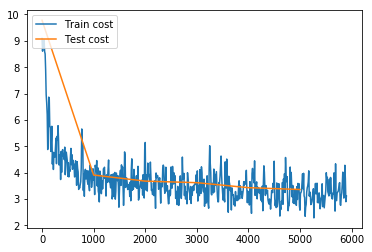

In [ ]:
trainer.train(
    reader=paddle.batch(
            paddle.reader.shuffle(
            paddle.dataset.movielens.train(), buf_size=8192),
                            batch_size=256),
    event_handler=event_handler_plot,
    feeding=feeding,
    num_passes=2)




![png](./image/output_32_0.png)

## 应用模型

在训练了几轮以后，您可以对模型进行推断。我们可以使用任意一个用户ID和电影ID，来预测该用户对该电影的评分。示例程序为:




In [1]:
import copy
user_id = 234
movie_id = 345

user = user_info[user_id]
movie = movie_info[movie_id]

feature = user.value() + movie.value()

infer_dict = copy.copy(feeding)
del infer_dict['score']

prediction = paddle.infer(inference, parameters=parameters, input=[feature], feeding=infer_dict)
score = (prediction[0][0] + 5.0) / 2
print "[Predict] User %d Rating Movie %d With Score %.2f"%(user_id, movie_id, score)



    [INFO 2017-03-06 17:17:08,132 networks.py:1472] The input order is [user_id, gender_id, age_id, job_id, movie_id, category_id, movie_title]
    [INFO 2017-03-06 17:17:08,134 networks.py:1478] The output order is [__cos_sim_0__]


    [Predict] User 234 Rating Movie 345 With Score 4.16


## 总结

本章介绍了传统的推荐系统方法和YouTube的深度神经网络推荐系统，并以电影推荐为例，使用PaddlePaddle训练了一个个性化推荐神经网络模型。推荐系统几乎涵盖了电商系统、社交网络、广告推荐、搜索引擎等领域的方方面面，而在图像处理、自然语言处理等领域已经发挥重要作用的深度学习技术，也将会在推荐系统领域大放异彩。

## 参考文献

1. [Peter Brusilovsky](https://en.wikipedia.org/wiki/Peter_Brusilovsky) (2007). *The Adaptive Web*. p. 325.
2. Robin Burke , [Hybrid Web Recommender Systems](http://www.dcs.warwick.ac.uk/~acristea/courses/CS411/2010/Book%20-%20The%20Adaptive%20Web/HybridWebRecommenderSystems.pdf), pp. 377-408, The Adaptive Web, Peter Brusilovsky, Alfred Kobsa, Wolfgang Nejdl (Ed.), Lecture Notes in Computer Science, Springer-Verlag, Berlin, Germany, Lecture Notes in Computer Science, Vol. 4321, May 2007, 978-3-540-72078-2.
3. P. Resnick, N. Iacovou, etc. “[GroupLens: An Open Architecture for Collaborative Filtering of Netnews](http://ccs.mit.edu/papers/CCSWP165.html)”, Proceedings of ACM Conference on Computer Supported Cooperative Work, CSCW 1994. pp.175-186.
4. Sarwar, Badrul, et al. "[Item-based collaborative filtering recommendation algorithms.](http://files.grouplens.org/papers/www10_sarwar.pdf)" *Proceedings of the 10th international conference on World Wide Web*. ACM, 2001.
5. Kautz, Henry, Bart Selman, and Mehul Shah. "[Referral Web: combining social networks and collaborative filtering.](http://www.cs.cornell.edu/selman/papers/pdf/97.cacm.refweb.pdf)" Communications of the ACM 40.3 (1997): 63-65. APA
6. Yuan, Jianbo, et al. ["Solving Cold-Start Problem in Large-scale Recommendation Engines: A Deep Learning Approach."](https://arxiv.org/pdf/1611.05480v1.pdf) *arXiv preprint arXiv:1611.05480* (2016).
7. Covington P, Adams J, Sargin E. [Deep neural networks for youtube recommendations](https://static.googleusercontent.com/media/research.google.com/zh-CN//pubs/archive/45530.pdf)[C]//Proceedings of the 10th ACM Conference on Recommender Systems. ACM, 2016: 191-198.


<br/>
<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="知识共享许可协议" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" href="http://purl.org/dc/dcmitype/Text" property="dct:title" rel="dct:type">本教程</span> 由 <a xmlns:cc="http://creativecommons.org/ns#" href="http://book.paddlepaddle.org" property="cc:attributionName" rel="cc:attributionURL">PaddlePaddle</a> 创作，采用 <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">知识共享 署名-相同方式共享 4.0 国际 许可协议</a>进行许可。
